github: [ptonso](https://github.com/ptonso)

# Questionário 4 - Introdução a Ciência de Dados

## Limpeza e setup

Nessa seção, iremos importar as ferramentas, limpar os dados e organizá-los para a modelagem


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import make_pipeline


seed = 123
test_size = .3

In [2]:
boston = pd.read_csv("data/BostonHousing.csv")


# Assuming the target (price) for boston house lies in "medv"
boston_y = boston['medv']
boston_X = boston.iloc[:,:-1]

boston_scaler = StandardScaler()
boston_X = np.array(boston_scaler.fit_transform(boston_X))

boston_y = boston_y.values.reshape(-1, 1)
boston_y = np.array(boston_scaler.fit_transform(boston_y)).flatten()


In [3]:
wine = pd.read_csv('data/winequality-red.csv')


wine_y = wine['quality']
wine_X = wine.iloc[:,:-1]

wine_scaler = StandardScaler()
wine_X = np.array(wine_scaler.fit_transform(wine_X))

wine_le = LabelEncoder()
wine_le.fit(wine_y)
wine_y = wine_le.transform(wine_y)


In [4]:
vehicle = pd.read_csv("data/Vehicle.csv")

vehicle_y = vehicle['Class']
vehicle_X = vehicle.iloc[:,:-1]

vehicle_scaler = StandardScaler()
vehicle_X = np.array(vehicle_scaler.fit_transform(vehicle_X))

vehicle_le = LabelEncoder()
vehicle_le.fit(vehicle_y)
vehicle_y = vehicle_le.transform(vehicle_y)



In [5]:
# Implementei o k-fold a mão para aprender o funcionamento


from sklearn.base import clone
from sklearn.metrics import accuracy_score

def k_fold_cv(model, X, y, k=3, metric=accuracy_score):

    X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
    y = y.to_numpy() if isinstance(y, pd.DataFrame) else y
    
    n_samples = X.shape[0]
    fold_size = n_samples // k

    performances = []

    for i in range(k):
        start = i * fold_size
        end = start + fold_size if i != k - 1 else n_samples
        X_test, y_test = X[start:end], y[start:end]

        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])
        
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)

        performance = metric(y_test, y_pred)
        performances.append(performance)
    
    return performances



In [6]:

boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(boston_X, boston_y, test_size=test_size, random_state=seed)
vehicle_X_train, vehicle_X_test, vehicle_y_train, vehicle_y_test = train_test_split(vehicle_X, vehicle_y, test_size=test_size, random_state=seed)


data = {
    'boston': {
        'X_train':boston_X_train,
        'X_test':boston_X_test,
        'y_train':boston_y_train,
        'y_test':boston_y_test,
    },
    'vehicle': {
        'X_train':vehicle_X_train,
        'X_test':vehicle_X_test,
        'y_train':vehicle_y_train,
        'y_test':vehicle_y_test,
    }
}


## Questão 1

Considere a base BostonHousing. Compare o coeficiente R2 obtido através de regressão linear múltipla, Lasso e ridge regression. Para os métodos Lasso e ridge regression, faça um gráfico de  conforme feito no notebook da aula.

best R^2 score for Lasso: 0.6311


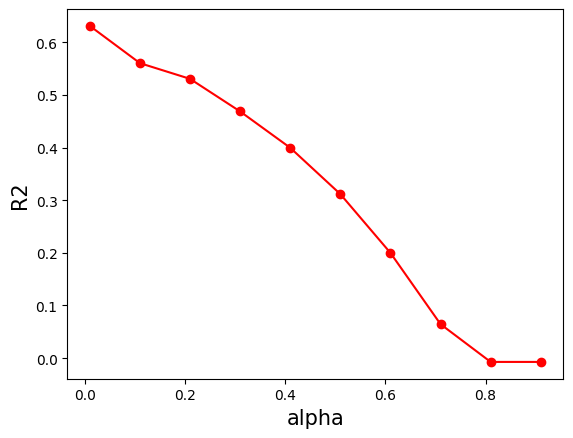

best R^2 score for Ridge: 0.6486


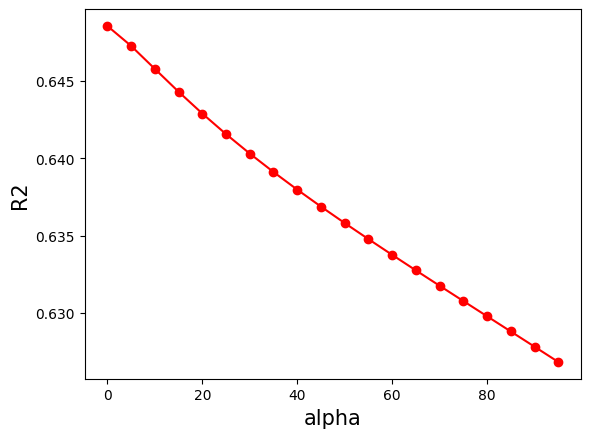

R^2 score for LinearRegression: 0.6486


In [7]:

lin_reg = LinearRegression
lasso_reg = Lasso
ridge_reg = Ridge

def r2_alpha(model_class, data, range):
    vR2 = []
    valpha = []
    for alpha in range:
        model = model_class(alpha)
        model.fit(data['X_train'], data["y_train"])
        y_pred = model.predict(data["X_test"])
        r2 = r2_score(data["y_test"], y_pred)
        vR2.append(r2)
        valpha.append(alpha)

    print(f"best R^2 score for {model.__class__.__name__}: {np.max(vR2):.4f}")

    plt.plot(valpha, vR2, '-ro')
    plt.xlabel("alpha", fontsize=15)
    plt.ylabel("R2", fontsize=15)
    plt.show(True)
    return vR2



lasso_r2 = r2_alpha(lasso_reg, data['boston'], np.arange(.01, 1, 0.1))
ridge_r2 = r2_alpha(ridge_reg, data['boston'], np.arange(0, 100, 5))


model = lin_reg()
model.fit(data['boston']['X_train'], data['boston']["y_train"])
y_pred = model.predict(data['boston']["X_test"])
r2 = r2_score(data['boston']["y_test"], y_pred)

print(f"R^2 score for {model.__class__.__name__}: {np.mean(r2):.4f}")



Nota-se que a performance dos modelos de Lasso e Ridged Regression tendem a cair quanto maior o parâmetro $\alpha$

Obtivemos nos três modelos performances bastante parecidas, talvez refletindo uma incapacidade de previsão melhores (variância irredutível) ou uma incapacidade de acesso a essa maior acurácia com modelos lineares.


## Questão 2

Determine as variáveis que mais influenciam o preço de imóveis em Boston usando Lasso.



In [8]:
model = lasso_reg(alpha=.1)
model.fit(data['boston']['X_train'], data['boston']["y_train"])

columns = boston.columns[:-1]


coefficients_df = pd.DataFrame({
    'Feature': columns,
    'Coefficient': model.coef_
})

coefficients_df = coefficients_df.sort_values(by='Coefficient', key=abs, ascending=False)
print(coefficients_df)

    Feature  Coefficient
5        rm     0.367099
12    lstat    -0.356972
10  ptratio    -0.154318
0      crim    -0.006380
1        zn     0.000000
4       nox    -0.000000
3      chas     0.000000
2     indus    -0.000000
6       age    -0.000000
8       rad    -0.000000
7       dis    -0.000000
9       tax    -0.000000
11        b     0.000000



pelos resultados, nota-se que as variáveis mais preditivas para o boston housing são $rm$ (relação positiva linear) e $lstat$ (relação negative linear), e com menor importância $ptratio$.
As demais variáveis foram praticamente ou totalemente excluidas da previsão por não conterem informação linear para a predição.


## Questão 3

Considere os dados gerados com o código a seguir. Usando regularização, ajuste o grau do polinômio que define o modelo mais adequado.


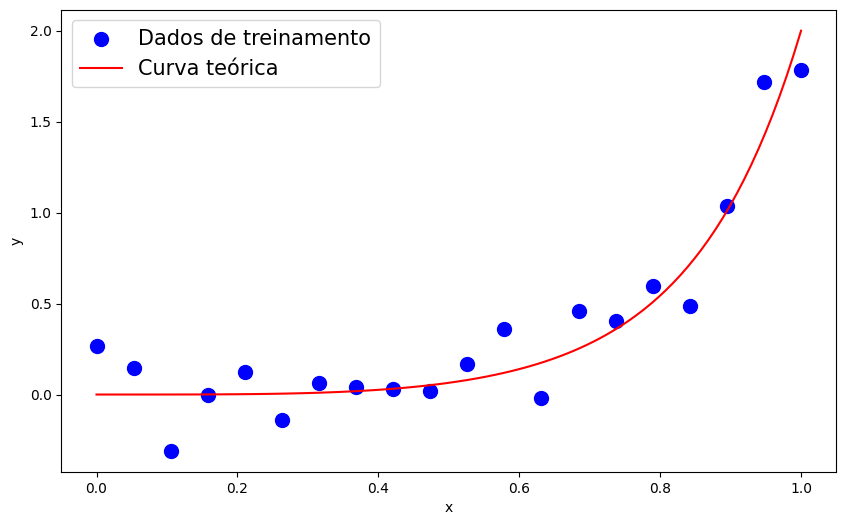

Degree 1: Train Error = 0.1251, Test Error = 0.1290
Degree 2: Train Error = 0.0576, Test Error = 0.0833
Degree 3: Train Error = 0.0376, Test Error = 0.0650
Degree 4: Train Error = 0.0309, Test Error = 0.0557
Degree 5: Train Error = 0.0283, Test Error = 0.0508
Degree 6: Train Error = 0.0272, Test Error = 0.0483
Degree 7: Train Error = 0.0268, Test Error = 0.0471
Degree 8: Train Error = 0.0267, Test Error = 0.0467
Degree 9: Train Error = 0.0267, Test Error = 0.0466
Degree 10: Train Error = 0.0268, Test Error = 0.0466


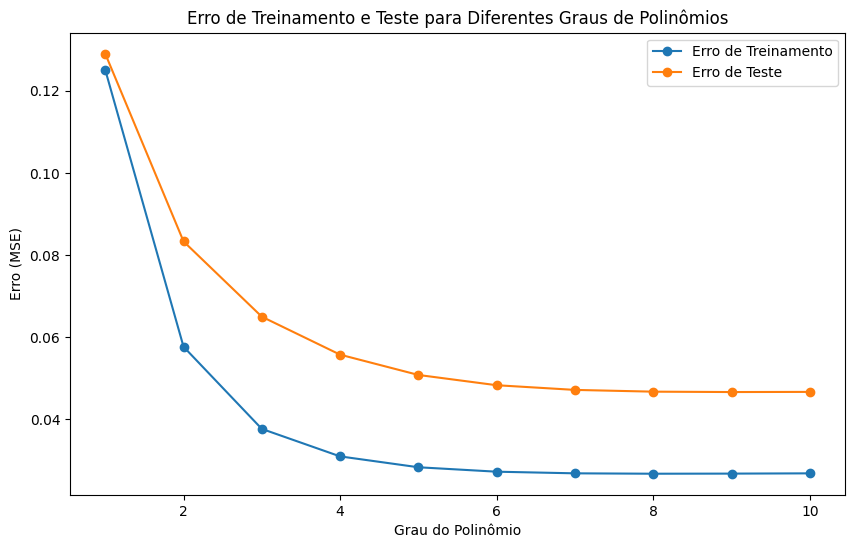

In [9]:
def function(x):
    return x**4 + x**9

np.random.seed(10)
N_train = 20
sigma = 0.2

x_train = np.linspace(0, 1, N_train).reshape(-1, 1)
y_train = function(x_train.flatten()) + np.random.normal(0, sigma, N_train)

N_test = 20
x_test = np.linspace(0, 1, N_test).reshape(-1, 1)
y_test = function(x_test.flatten()) + np.random.normal(0, sigma, N_test)

fig = plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, facecolor="blue", edgecolor="b", s=100, label="Dados de treinamento")

xt = np.linspace(0, 1, 100).reshape(-1, 1)
yt = function(xt.flatten())
plt.plot(xt, yt, '-r', label="Curva teórica")

plt.xlabel("x")
plt.ylabel("y")
plt.legend(fontsize=15)
plt.show()

degrees = [i for i in range(1,11)]
errors_train = []
errors_test = []

alpha = 0.1

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    errors_train.append(train_error)
    errors_test.append(test_error)
    
    print(f"Degree {degree}: Train Error = {train_error:.4f}, Test Error = {test_error:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(degrees, errors_train, label="Erro de Treinamento", marker='o')
plt.plot(degrees, errors_test, label="Erro de Teste", marker='o')
plt.xlabel("Grau do Polinômio")
plt.ylabel("Erro (MSE)")
plt.title("Erro de Treinamento e Teste para Diferentes Graus de Polinômios")
plt.legend()
plt.show()

Enquanto o grau do polinômio aumenta, nota-se uma redução no erro no treinamento e no teste até estabilizar em $p=8$

## Questão 4

Realize a classificação da base Vehicles usando validação cruzada e o método grid_search para escolher os melhores hiperparâmetros do modelo regressão logística e knn.

In [10]:


logistic_params = {'C': [0.01, 0.1, 1, 10, 100]}
knn_params = {'n_neighbors': [3, 5, 7, 9], 'p': [1, 2]}

logistic_model = LogisticRegression(max_iter=1000)
knn_model = KNeighborsClassifier()

best_logistic_score = 0
best_logistic_params = None
for params in ParameterGrid(logistic_params):
    logistic_model.set_params(**params)
    scores = k_fold_cv(logistic_model, vehicle_X, vehicle_y, k=5)
    score = np.mean(scores)
    if score > best_logistic_score:
        best_logistic_score = score
        best_logistic_params = params

best_knn_score = 0
best_knn_params = None
for params in ParameterGrid(knn_params):
    knn_model.set_params(**params)
    scores = k_fold_cv(knn_model, vehicle_X, vehicle_y, k=5)
    score = np.mean(scores)
    if score > best_knn_score:
        best_knn_score = score
        best_knn_params = params

print(f"Best Logistic Regression params: {best_logistic_params}, Accuracy: {best_logistic_score:.4f}")
print(f"Best KNN params: {best_knn_params}, Accuracy: {best_knn_score:.4f}")


Best Logistic Regression params: {'C': 10}, Accuracy: 0.8061
Best KNN params: {'n_neighbors': 7, 'p': 1}, Accuracy: 0.7222


## Questão 5

Verifique se o número de folds, usado na validação cruzada, influencia na classificação da base winequality-red. Use o modelo de regressão logística.



2-fold CV: Accuracy = 0.5666
3-fold CV: Accuracy = 0.5891
5-fold CV: Accuracy = 0.5822
7-fold CV: Accuracy = 0.5853
10-fold CV: Accuracy = 0.5867


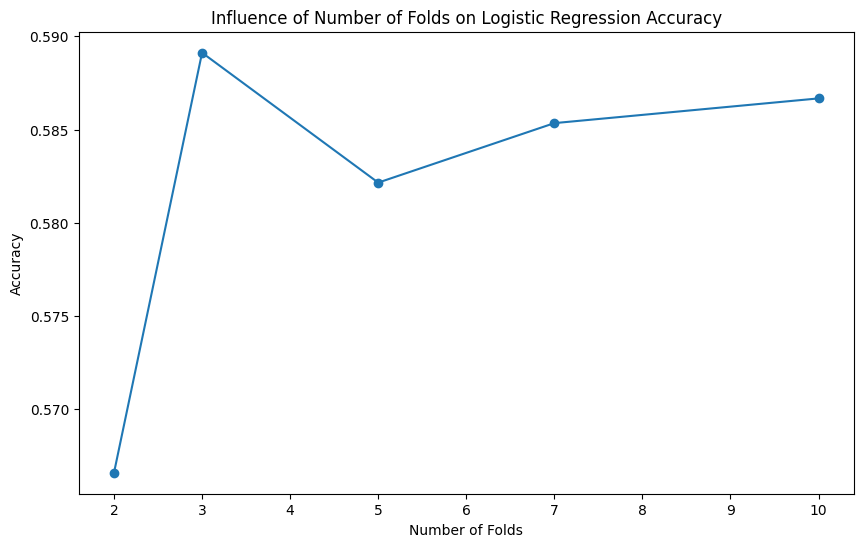

In [11]:


from sklearn.linear_model import LogisticRegression
import numpy as np

folds = [2, 3, 5, 7, 10]

logistic_model = LogisticRegression(max_iter=1000)

results = []

for k in folds:
    scores = k_fold_cv(logistic_model, wine_X, wine_y, k=k)
    mean_score = np.mean(scores)
    results.append((k, mean_score))
    print(f"{k}-fold CV: Accuracy = {mean_score:.4f}")

results_df = pd.DataFrame(results, columns=["Folds", "Accuracy"])

plt.figure(figsize=(10, 6))
plt.plot(results_df["Folds"], results_df["Accuracy"], marker='o')
plt.xlabel("Number of Folds")
plt.ylabel("Accuracy")
plt.title("Influence of Number of Folds on Logistic Regression Accuracy")
plt.show()





Nota-se uma grande diferença na avaliação partindo de $k=2$ até $k=3$.
Esse padrão atesta para a importância de se usar uma validação cruzada, já que apenas a seleção por treino-teste pode ser entendida como um caso particular com $k=2$ e com $.5$ usado para teste, o que sugere que mais folds podem melhorar a robustez da avaliação.

